In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import os
from PIL import Image

from typing import Any
from google.colab import drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Kaggle/'
%cd '/content/drive/MyDrive/Kaggle'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
%ls
input_file = 'chest-xray-pneumonia.zip'
output_folder = 'chest-xray-pneumonia'
%cd 'chest-xray-pneumonia/chest_xray'
%ls
!unzip {input_file} -d {output_folder}

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/N

In [ ]:
root_dir = 'chest-xray-pneumonia/chest_xray/'
train_data_path = 'train'
test_data_path = 'test'
val_data_path = 'val'
%ls

chest-xray-pneumonia/  chest-xray-pneumonia.zip  kaggle.json


In [ ]:
train_transforms =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#test and validation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir: str, *args, **kwargs) -> None:
        self.train_data = None
        self.test_data = None
        self.val_data = None
        pass

    def __len__(self,) -> int:
        pass

    def __getitem__(self,) -> Any:
        pass

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    root=root_dir + train_data_path,
    transform=train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    root=root_dir + test_data_path,
    transform=test_transforms
)
val_dataset = torchvision.datasets.ImageFolder(
    root=root_dir + val_data_path,
    transform=test_transforms
)
BATCH_SIZE = 16

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader.dataset))
print(len(test_loader.dataset))

classes = train_dataset.classes
print(classes)
print(train_dataset.class_to_idx)

5216
624
['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


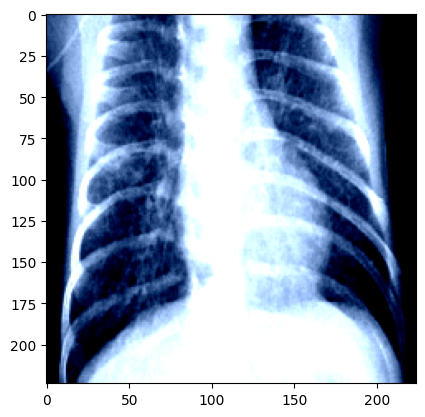

Label: 1


In [ ]:
 train_features, train_labels = next(iter(train_loader))
 print(f"Feature batch shape: {train_features.size()}")
 print(f"Labels batch shape: {train_labels.size()}")
 img = train_features[0].squeeze().permute(1,2,0)
 label = train_labels[1]
 plt.imshow(img)
 plt.show()
 print(f"Label: {label}")

In [ ]:
class Network(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)
        # ((width - kernel_size + 2*padding)/stride) + 1
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        # shape now is 16, 12, 112, 112
        self.conv2 = nn.Conv2d(12, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        #16, 16, 112, 112
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        #hardcoded out_features but same as number of classes -> (NORMAL, PNEUMONIA) = 2
        self.fc1 = nn.Linear(32*112*112, out_features=784)
        self.fc2 = nn.Linear(784, 49)
        self.drop = nn.Dropout(0.5)
        self.fc3 = nn.Linear(49, 2)


    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        #fc -> we need to reshape it
        output = output.view(-1, 32*112*112)
        output = self.fc1(output)
        output = self.fc2(output)
        # dropout only for training !!!
        output = self.drop(output)
        output = self.fc3(output)
        return output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
net = Network()
net.to(device)

cuda


Network(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=401408, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=49, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=49, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    net.train()
    training_loss = 0.0
    valid_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)
    training_loss /= len(train_loader.dataset)
    writer.add_scalar('Loss/train', training_loss, epoch)
    net.eval()
    num_correct = 0
    num_examples = 0
    for i, data in enumerate(val_loader, 0):
        optimizer.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        valid_loss += loss.data.item() * inputs.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1],
                               labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    valid_loss /= len(val_loader.dataset)
    writer.add_scalar('Loss/valid', valid_loss, epoch)
    writer.add_scalar('accuracy', num_correct / num_examples, epoch)
    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
print('Finished Training')
writer.flush() # to make sure all is saved to disk

Epoch: 0, Training Loss: 17.70, Validation Loss: 0.00, accuracy = 1.00
Epoch: 1, Training Loss: 1.48, Validation Loss: 0.14, accuracy = 0.94
Epoch: 2, Training Loss: 0.30, Validation Loss: 0.11, accuracy = 0.94
Epoch: 3, Training Loss: 0.14, Validation Loss: 0.48, accuracy = 0.81
Epoch: 4, Training Loss: 0.11, Validation Loss: 0.21, accuracy = 0.88
Epoch: 5, Training Loss: 0.09, Validation Loss: 0.16, accuracy = 0.88
Epoch: 6, Training Loss: 0.11, Validation Loss: 0.27, accuracy = 0.88
Epoch: 7, Training Loss: 0.10, Validation Loss: 1.42, accuracy = 0.62
Epoch: 8, Training Loss: 0.10, Validation Loss: 0.32, accuracy = 0.88
Epoch: 9, Training Loss: 0.11, Validation Loss: 0.79, accuracy = 0.75
Finished Training


In [ ]:
writer.close()
!pip install tensorboard
!tensorboard --logdir=runs

2024-04-24 08:33:03.573696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 08:33:03.573747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 08:33:03.575142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 08:33:04.651742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 